## Data collection

In [1]:
import os, sys, random
from numpy import mat
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifParser, CifFile
import json
import csv
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

In [2]:
API_TOKEN = os.environ.get("MPTOKEN")
# print(API_TOKEN)

In [3]:
mpr = MPRester(API_TOKEN)

crt = {
    # 'elements': {'$all': ['N']},
    'nelements': 3,
    'band_gap': {'$lt': 1},
    # 'anonymous_formula': {"A": 1, "B": 1, "C": 3}
}
prt = ['material_id', 'pretty_formula', 'full_formula', 'band_gap', 'unit_cell_formula', 'elements']

materials = mpr.query(criteria=crt, properties=prt)

100%|██████████| 42042/42042 [02:07<00:00, 330.75it/s]


In [5]:
CANDIDATE_IDS = []

for material in materials:
    CANDIDATE_IDS.append(material['material_id'])

print(CANDIDATE_IDS[:5])

['mp-983586', 'mp-1183079', 'mp-1183067', 'mp-1183063', 'mp-862549']


In [6]:
## Get the cif data


mpr = MPRester(API_TOKEN)

crt = {
    'material_id': {'$in': CANDIDATE_IDS},
}
prt = ['material_id', 'pretty_formula', 'icsd_ids', 'cif', 'elasticity']

cif_candidates = mpr.query(criteria=crt, properties=prt)

100%|██████████| 42042/42042 [03:26<00:00, 203.27it/s]


In [11]:
for mat in cif_candidates[:5]:
    if mat['elasticity'] is None:
        print(mat['material_id'], mat['pretty_formula'])

mp-1001015 Y2ZnS4


In [12]:
## Find all the materials with elastic properties


ID_PROPS_DATA = []
count = 1
for i in cif_candidates:
    if i['elasticity'] is not None:
        # print(f"processing {i['pretty_formula']}")
        
        ## Create CIF files from
        mat_name = f"{i['pretty_formula']}_{i['material_id']}"
        bulk_modulus = i['elasticity']['K_VRH']

        with open(f"cgcnn-mod-transformers/data/transformers-reg/{mat_name}.cif", 'w') as ff: 
            ff.write(i['cif'])
        
        ## Create csv data
        ID_PROPS_DATA.append([mat_name, bulk_modulus])
        
        # break
        count+=1

        # if count >= 20: break

with open("cgcnn-mod-transformers/data/transformers-reg/id_prop.csv", 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)


print(count)

5659


## Training

In [13]:
ROOT_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])

main_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/main.py")
data_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/data/transformers-reg")
python_exe = os.path.join(ROOT_DIR, "venv/Scripts/python.exe")

EPOCHS = 150
run_options = f"--train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs {EPOCHS}"


cmd = f"python \"{main_file}\" {run_options} \"{data_file}\""
print(cmd)

result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
print(result.stdout.decode("utf-8"))


python "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/main.py" --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs 20 "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/data/transformers-reg"
Epoch: [0][0/14]	Time 7.493 (7.493)	Data 5.664 (5.664)	Loss 2.4497 (2.4497)	MAE 83.445 (83.445)
Epoch: [0][10/14]	Time 5.954 (6.391)	Data 5.161 (5.477)	Loss 1.3100 (2.6855)	MAE 59.717 (78.389)
Test: [0/5]	Time 5.462 (5.462)	Loss 1.5673 (1.5673)	MAE 57.659 (57.659)
 * MAE 52.178
Epoch: [1][0/14]	Time 0.818 (0.818)	Data 0.017 (0.017)	Loss 1.2286 (1.2286)	MAE 47.702 (47.702)
Epoch: [1][10/14]	Time 0.848 (0.830)	Data 0.014 (0.014)	Loss 0.2437 (0.5936)	MAE 22.869 (33.309)
Test: [0/5]	Time 0.222 (0.222)	Loss 1.0736 (1.0736)	MAE 47.410 (47.410)
 * MAE 44.750
Epoch: [2][0/14]	Time 0.822 (0.822)	Data 0.017 (0.017)	Loss 0.5391 (0.5391)	MAE 27.059 (27.059)
Epoch: [2][10/14]	Time 0.807 (0.833)	Data 

<AxesSubplot:title={'center':'Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [Epochs=20, TOTAL-DATASET=5659, Train-Validation-Test_Ratios=6:2:2]'}, xlabel='material'>

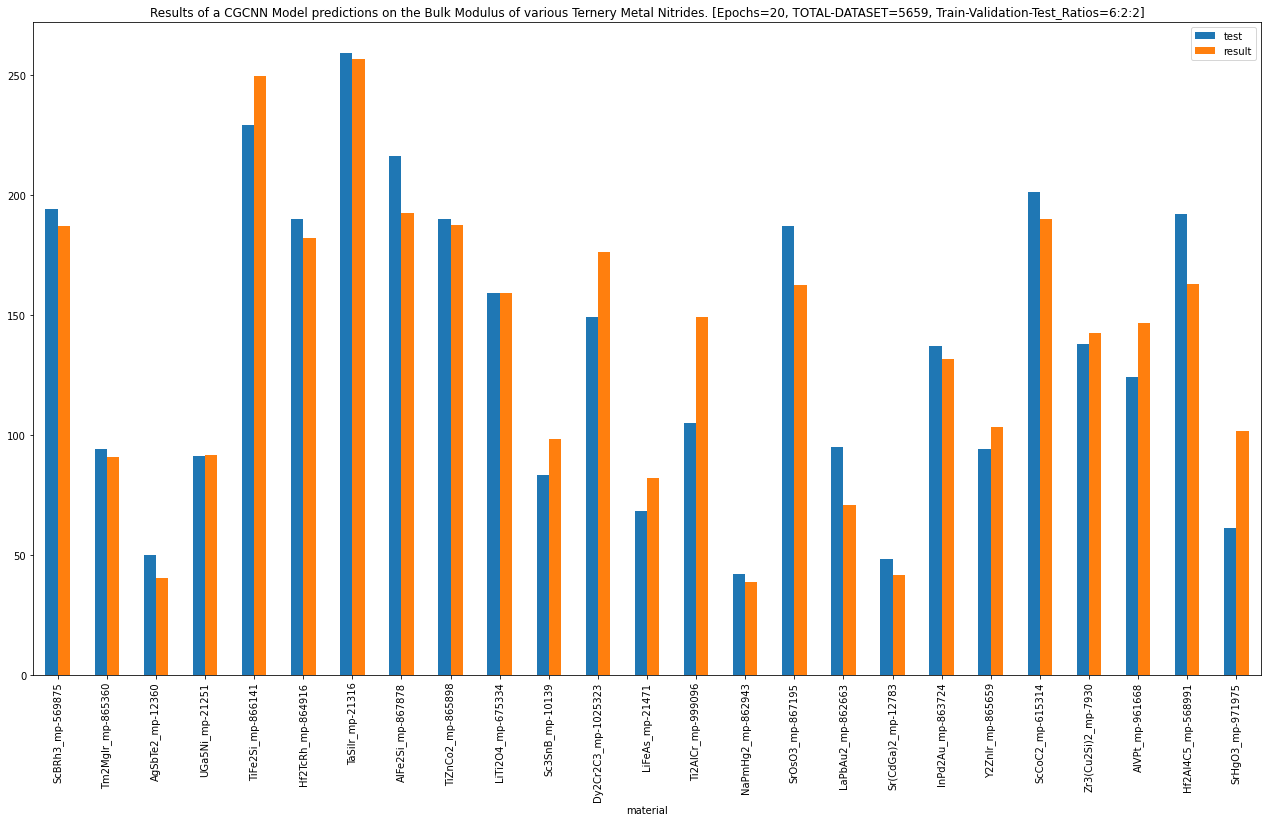

In [19]:
result_file = os.path.join(ROOT_DIR, "src/test_results.csv")

df = pd.read_csv(result_file)[:50]
df.dropna(subset=['material'], inplace=True)
df.head()
df.plot(x="material", y=["test", "result"], kind='bar', figsize=(22, 12),
        title=f"Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [Epochs={EPOCHS}, TOTAL-DATASET={count}, Train-Validation-Test_Ratios=6:2:2]",
        sort_columns=True)


<AxesSubplot:xlabel='test', ylabel='result'>

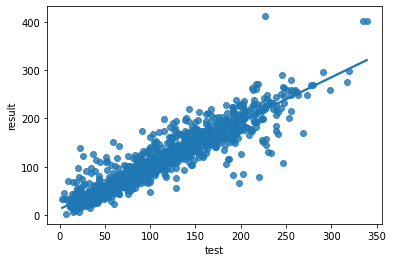

In [17]:
sb.regplot(x = "test",
        y = "result",
        ci = None,
        data = df)